In [3]:
from __future__ import division
from __future__ import print_function
from collections import namedtuple
import datetime
import dateutil.parser
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import pandas.io.gbq
import pickle
from sklearn.model_selection import KFold
%matplotlib inline

# This is a DAGEROUS workaround to having two KMP libraries linked
# Would be better to figure out conflict
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plt.rcParams['figure.figsize'] = [10, 5]

from track_based_models import longline_data, predict_longline_setting, longline_sets_models
from track_based_models import util
from track_based_models.util import minute, hour

In [4]:
# Step 1. Figure out where we are going to get the train and test data
# Break up by boat – if we validate using the same boat validated by
# two different people it will wildly optimistic

paths = sorted((glob("../birdlife/labeled_data/without_logbook_data/*.json") +
                glob("../birdlife/labeled_data/with_logbook_data/*.json")))

all_paths = paths + glob("../birdlife/unlabelled_data/*.json") + glob("../../birdlife/allboats/*.json")

In [5]:
ssvid = sorted(set([os.path.basename(x).split('_')[0] for x in paths]))

In [6]:
query = '''
select * from 
(select id as ssvid, * from `machine_learning_dev_ttl_120d.test_loitering_features_mmsi_2_2017*`
) features
where 
ssvid in ({})
order by timestamp
'''.format(
','.join(['"{}"'.format(x) for x in ssvid])
)
all_features = pd.read_gbq(query, project_id='world-fishing-827', dialect='standard')

//anaconda/envs/p3ml/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [7]:
len(set(all_features.ssvid)) # 13

13

## Cross Validation

In [22]:
import imp, track_based_models.longline_sets_models, track_based_models.longline_data
imp.reload(track_based_models.base_model)
imp.reload(track_based_models.longline_sets_models)
imp.reload(track_based_models.longline_data)
imp.reload(track_based_models.util)
from track_based_models.longline_sets_models import ConvNetModel5

max_epochs = 30
keep_fracs = [1, 0.75, 0.5, 0.25]
batch_size = 32

f1_scores = []
class_b_f1_scores = []
david_class_b_f1_scores = []

def test_model(mdl, test_sets, min_samples, keep_frac=1.0):
    times, features, labels, _, defined = longline_data.generate_data(test_sets, 
                                                window=ConvNetModel5.window, delta=ConvNetModel5.delta, 
                                               min_samples=1000, keep_fracs=(keep_frac,), noise=0,
                                               precomp_features=all_features)
    predictions = mdl.predict(features)
    print("model accuracy:", accuracy_score(labels, predictions, sample_weight=defined))
    precision, recall, fscore, support = precision_recall_fscore_support(labels, predictions, sample_weight=defined)
    print("model precision:", precision[1])
    print("model recall:", recall[1])
    print("model f1-score:", fscore[1])
    print("model set support:", support[1])
    print()
    return fscore
    

data_sets = paths

    
folder = KFold(n_splits=5, random_state=888, shuffle=True)
all_agreements = {}
for i, (train_index, test_index) in enumerate(folder.split(data_sets)):
    print("Fold", i)
    data_sets_array = np.asarray(data_sets)
    train_sets = data_sets_array[train_index]
    test_sets = data_sets_array[test_index]
    
    # Train the model
    print('generating data')
    xtimes, xfeatures, xlabels, _, xdefined = longline_data.generate_data(train_sets, min_samples=1000, 
                                                                        window=longline_model.ConvNetModel5.window, 
                                                                          delta=longline_model.ConvNetModel5.delta, 
                                                                        keep_fracs=keep_fracs,
                                                                       force_local=False, 
                                                                          precomp_features=all_features)
    print('training')
    mdl = longline_model.ConvNetModel5().fit(xfeatures, xlabels, epochs=max_epochs, 
                              sample_weight=xdefined, batch_size=batch_size)

    
    # Test the model
    print('testing')
    fscore = test_model(mdl, test_sets, min_samples=1000)
    f1_scores.append(fscore[1])

        
print("Score derived from random sampling:")
print("  Average F1-Score:", np.mean(f1_scores))
# 0.9167440972301417 11, one sided
# 0.910695424990904  5, one sided
#   Average F1-Score: 0.9223069457487714 # 30 epochs 5, one-sided

NameError: name 'KFold' is not defined

In [23]:
# Train the model on all of the data
times, features, labels, _, defined = track_based_models.longline_data.generate_data(data_sets, min_samples=1000, 
                                                                          window=mdl.window, 
                                           delta=mdl.delta, keep_fracs=keep_fracs, precomp_features=all_features)
mdl_all = ConvNetModel5().fit(features, labels, epochs=30)

NameError: name 'mdl' is not defined

1. (X) Train on all.
2. (X) Save as h5 file
3. (X) Get standalone working.
4. ( ) Run features for all of 2017
5. ( ) Copy run iference using the Keras version -- should be easier!
6. ( ) Run on all longliners for 2017.
7. ( ) Have someone spot check.
8. ( ) Copy over to loitering.

In [50]:
# mdl_all.save('longline_model_v20190612.h5')

## Compare With Original

In [8]:
with open('data/birdlife_ais_data.pkl', 'rb') as f:
    birdlife_ais_data = pickle.load(f)

In [9]:
def compare(obj, times, predictions):
    p = obj['path'].replace('../..', '..')
    with open(p) as f:
        orig_obj = json.load(f)
        orig = pd.DataFrame({
            'timestamp' : orig_obj['timestamps'],
            'fishing' : orig_obj['fishing'],
            'mmsi' : [orig_obj['mmsi']] * len(orig_obj['timestamps'])
        })
    orig['timestamp'] = [dateutil.parser.parse(x) for x in orig['timestamp']]
    data = add_predictions(orig, times, predictions)
    assert len(data) == len(orig.timestamp)#, (len(data), len(orig['timestamp']))
    inferred = data.inferred_setting.values
    annotated = data.fishing.values
    defined = (data.fishing != 0)
    mask = ~np.isnan(inferred) & ~np.isnan(annotated) & defined
    match = (inferred == 1) == (annotated == 1)
    true_pos = (match & (annotated == 1))[mask].sum()
    all_true = (inferred == 1)[mask].sum()
    all_pos  = (annotated == 1)[mask].sum()
    prec = true_pos / all_pos
    rec = true_pos / all_true
    f1 = 2 / (1 / prec + 1 / rec)
    acc = match[mask].sum() / mask.sum()
    orig_obj['timestamps'] = [dateutil.parser.parse(x) for x in orig_obj['timestamps']]
    return orig_obj, data, {'accuracy' : acc, 'F1' : f1, 'precision' : prec, 'recall' : rec}

def add_predictions(data, times, predictions):
    preds = np.empty(len(data), dtype=float)
    assert len(times) == len(predictions)
    timestamps = [x.to_pydatetime() for x in data.timestamp]
    assert util.is_sorted(timestamps)
    preds.fill(np.nan)
    for t, p in zip(times, predictions):
        t0 = t - datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        t1 = t + datetime.timedelta(seconds=ConvNetModel5.delta // 2)
        i0 = np.searchsorted(timestamps, t0, side='left')
        i1 = np.searchsorted(timestamps, t1, side='right')
        preds[i0:i1] = p
    data = data.copy()
    data['inferred_setting'] = preds
    return data

In [25]:
import imp, track_based_models.longline_sets_models, track_based_models.longline_data
imp.reload(track_based_models.longline_sets_models)
imp.reload(track_based_models.longline_data)
imp.reload(track_based_models.predict_longline_setting)
from track_based_models.longline_sets_models import ConvNetModel5

imp.reload(predict_longline_setting)

metrics_list = []
objs_list = []
for base_obj in birdlife_ais_data:
    ssvid = base_obj['mmsi']
    t0 = base_obj['timestamps'][0]
    t1 = base_obj['timestamps'][-1]
    data = predict_longline_setting.features_to_data(all_features, ssvid, t0, t1)
    times, predictions = predict_longline_setting.predict_set_times(
                                    'gs://machine-learning-dev-ttl-120d/longline_model_v20190612.h5', data)
    orig_obj, orig, metrics = compare(base_obj, times, predictions)
    metrics_list.append(metrics)
    objs_list.append((orig_obj, orig, times, predictions))
    print('.', end='')

.....................................

In [26]:
print(len(metrics_list), np.mean([x['F1'] for x in metrics_list]))
# 0.8587006713736698 0.8765266861195162 0.8528620543033096 0.8507986578373596

37 0.8545812824063037


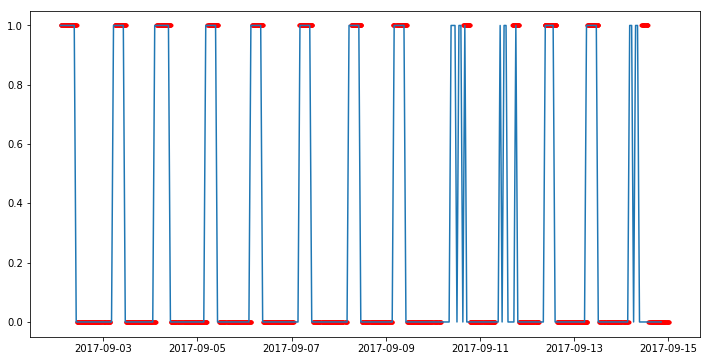

In [27]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(12, 6))
orig_obj, orig, times, predictions = objs_list[10]
mask = (orig['fishing'] != 0)
plt.plot(orig['timestamp'][mask], orig['fishing'][mask] == 1, 'r.')
plt.plot(times, predictions)